In [1]:
import os
import pickle
import random, tqdm
import numpy as np

from langchain.docstore.document import Document as LangchainDocument
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI

from prompt_templates import QAGenerationPrompts

In [ ]:
# Pydantic models for robust data validation
from pydantic import BaseModel, ValidationError, Field, field_validator
from typing import Optional, Dict, Any
import re

class QAPairResponse(BaseModel):
    """Model for validating QA pair generation response"""
    question: str = Field(..., min_length=10, description="The generated question")
    answer: str = Field(..., min_length=20, description="The generated answer")
    context: str = Field(..., description="The context used for generation")
    generation_successful: bool = Field(default=True, description="Whether generation was successful")
    
    @field_validator('question')
    @classmethod
    def validate_question(cls, v: str) -> str:
        """Ensure question is properly formatted"""
        v = v.strip()
        if not v.endswith('?'):
            raise ValueError('Question must end with a question mark')
        if len(v.split()) < 3:
            raise ValueError('Question must contain at least 3 words')
        return v
    
    @field_validator('answer')
    @classmethod### **Executive Summary**
    def validate_answer(cls, v: str) -> str:
        """Ensure answer is meaningful"""
        v = v.strip()
        if len(v.split()) < 1:
            raise ValueError('Answer must contain at least 5 words')
        return v

In [2]:
with open("data/processed/2025_1Q_LGES_Audit_Report_CONFS_en_fulltext.txt", 'r') as f:
    lges_2025_1q_fulltext = f.read()

In [3]:
with open("data/processed/2025_2Q_LGES_audit_report_summary.txt", 'r') as f:
    lges_2025_2q_summ = f.read()

with open("data/processed/2025_09_11_LGES_news_summary.txt", "r") as f:
    lges_2025_09_01_news_summary = f.read()

In [4]:
all_about_lges_text = lges_2025_2q_summ + "\n"+ lges_2025_09_01_news_summary

# Synthetic QA Dataset Generation

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

chunks = text_splitter.create_documents([all_about_lges_text])

# docs_processed = []
# for doc in langchain_docs:
#     docs_processed += text_splitter.split_documents([doc])

In [6]:
print(f"Number of chunks: {len(chunks)}")
print(f"Sample chunk length: {len(chunks[0].page_content) if chunks else 0}")
print(f"Total text length: {len(all_about_lges_text)}")

# Display first chunk as example
if chunks:
    print(f"\nFirst chunk preview:\n{chunks[0].page_content}...")


Number of chunks: 25
Sample chunk length: 980
Total text length: 16102

First chunk preview:
### **Executive Summary**

LG Energy Solution (LGES) stands as a global titan in the rapidly expanding battery industry, a critical enabler of the electric vehicle (EV) and energy storage system (ESS) revolution. Our long-term conviction in LGES remains strong, driven by its technological leadership, diversified customer base, aggressive capacity expansion, and strategic positioning to benefit from global decarbonization efforts.

However, the stock's valuation has historically commanded a premium, reflecting its growth prospects. **For investors looking to initiate or increase positions, our analysis suggests a patient and tactical approach, focusing on specific market conditions and operational catalysts rather than chasing momentum.** We believe optimal entry points will emerge during periods of market consolidation, temporary operational headwinds, or when the market underappreciates LGES's

In [7]:
gemini_flash = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0.1
)
print("✅ gemini-2.5-flash initialized")


# Initialize OpenAI generation model
gpt4o_mini = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.1
)

print("✅ gpt-4o-mini initialized")

✅ gemini-2.5-flash initialized
✅ gpt-4o-mini initialized


In [8]:
def get_model_name(llm):
    if hasattr(llm, 'model_name'):
        return llm.model_name
    elif hasattr(llm, 'model'):
        return llm.model.split("/")[-1]
    else:
        raise ValueError(f"Unsupported LLM type. Expected OpenAI or Gemini model, got: {type(llm).__name__}")


In [9]:
class LLMClient:
    def __init__(self, critique_model: str, generation_model: str):
        self.critique_llm = critique_model
        self.generation_llm = generation_model

        print("critique model: ", get_model_name(self.critique_llm))
        print("generation model: ", get_model_name(self.generation_llm))
    
llm_client = LLMClient(
    critique_model=gpt4o_mini,
    generation_model=gemini_flash
)

critique model:  gpt-4o-mini
generation model:  gemini-2.5-flash


In [48]:
# === 3. SYNTHETIC QA GENERATION PIPELINE ===

class SyntheticQAGenerator:
    """Generate synthetic QA pairs using LLM with quality filtering"""
    
    def __init__(self, llm_client: LLMClient):
        self.llm_client = llm_client
        self.qa_prompts = QAGenerationPrompts()
        
    def generate_qa_pair(self, company_name:str, context: str, question_type: str) :
        """Generate a single QA pair from context using Pydantic validation"""
        chain = self.qa_prompts.BASE_QA_GENERATION | self.llm_client.generation_llm
        response = chain.invoke({"company_name": company_name
                                , "question_type": question_type
                                , "context": context})
        
        # Pydantic-based parsing for robust validation
        response = response.content
        question_part = content.split("Factoid question:")[-1].split("Answer:")[0].strip()
        answer_part = content.split("Answer:")[1].strip()

        # Returns a dict
        qa_pair = QAPairResponse(
            question=question_part,
            answer=answer_part,
            question_type=question_type,
            context=context
        ).model_dump()

        return qa_pair

    
    def critique_qa_pair(self, qa_pair, critique_type):
        """Apply quality critique to QA pair"""
        if not qa_pair.get("generation_successful", False):
            return {"passed": False, "reason": "Generation failed"}
            
        prompt = self.qa_prompts.RELEVANCE_CRITIQUE[critique_type].format(
            question=qa_pair["question"],
            answer=qa_pair["answer"],
            context=qa_pair.get("context", ""),
            question_type=qa_pair.get("question_type", "")
        )
        
        try:
            response = self.llm_client.call_llm(prompt, max_tokens=200, temperature=0.3)
            
            # Parse response
            passed = "PASS" in response.upper()
            reason = ""
            if "Reason:" in response:
                reason = response.split("Reason:")[1].strip()
            
            return {"passed": passed, "reason": reason, "critique_type": critique_type}
            
        except Exception as e:
            return {"passed": False, "reason": f"Critique failed: {str(e)}", "critique_type": critique_type}
    
    def generate_filtered_qa_pairs(self, chunks, n_generations_per_type: int = 5, 
                                 apply_critiques: bool = True):
        """Generate QA pairs with quality filtering"""
        
        all_qa_pairs = []
        
        for question_type in QUESTION_TYPES.keys():
            print(f"\n🔄 Generating {question_type} questions...")
            
            successful_pairs = []
            attempts = 0
            max_attempts = n_generations_per_type * 3  # Allow more attempts than needed
            
            while len(successful_pairs) < n_generations_per_type and attempts < max_attempts:
                attempts += 1
                
                # Sample random chunk
                chunk = random.choice(chunks)
                context = chunk.page_content
                
                # Generate QA pair
                qa_pair = self.generate_qa_pair(context, question_type)
                
                if not qa_pair.get("generation_successful", False):
                    print(f"  ❌ Generation failed: {qa_pair.get('error', 'Unknown error')}")
                    continue
                
                # Apply critiques if enabled
                if apply_critiques:
                    critiques_passed = []
                    for critique_type in ["relevance", "clarity", "complexity"]:
                        critique_result = self.critique_qa_pair(qa_pair, critique_type)
                        critiques_passed.append(critique_result["passed"])
                        
                        if not critique_result["passed"]:
                            print(f"  ⚠️  Failed {critique_type}: {critique_result['reason']}")
                            break
                    
                    if not all(critiques_passed):
                        continue
                
                # Add metadata
                qa_pair.update({
                    "chunk_id": chunks.index(chunk),
                    "generation_attempt": attempts,
                    "critiques_applied": apply_critiques
                })
                
                successful_pairs.append(qa_pair)
                print(f"  ✅ Generated {question_type} question {len(successful_pairs)}/{n_generations_per_type}")
            
            all_qa_pairs.extend(successful_pairs)
            print(f"📊 Completed {question_type}: {len(successful_pairs)}/{n_generations_per_type} successful")
        
        return all_qa_pairs

In [49]:
# Initialize generator
qa_generator = SyntheticQAGenerator(llm_client)
print("✅ Synthetic QA generator initialized")

✅ Synthetic QA generator initialized


In [50]:
QAGenerationPrompts.QUESTION_TYPES

{'factual': 'Direct facts, dates, numbers, or specific information',
 'analytical': 'Analysis, interpretation, or synthesis requiring reasoning',
 'comparative': 'Comparisons between different aspects, periods, or entities',
 'strategic': 'Business strategy, plans, or strategic positioning',
 'risk': 'Challenges, risks, or potential issues and uncertainties'}

In [51]:
company_name = "LG Energy Solution"
question_type = "factual"

qa_pairs = []
for sample_doc in tqdm.tqdm(random.sample(chunks, int(len(chunks)*0.50))):
    qa_pair = qa_generator.generate_qa_pair(company_name, sample_doc.page_content, question_type)
    qa_pairs.append(qa_pair)

  0%|          | 0/12 [00:00<?, ?it/s]

 92%|█████████▏| 11/12 [00:41<00:03,  3.61s/it]Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 13
}
].
100%|██████████| 12/12 [00:50<00:00,  4.24s/it]


## Evaluate synthetic QA pairs

In [55]:
qa_pairs[:3]

[{'question': 'What raw materials affect gross margins?',
  'answer': 'Lithium, nickel, and cobalt.',
  'context': '6.  **Operational Execution:** Successfully ramping up numerous new, complex manufacturing facilities globally without significant delays or cost overruns is a continuous challenge.\n7.  **Product Recalls:** While past issues (e.g., GM Bolt, Hyundai Kona) have largely been resolved, any future large-scale recalls could damage reputation and incur significant costs.',
  'generation_successful': True},
 {'question': 'What raw materials affect gross margins?',
  'answer': 'Lithium, nickel, and cobalt.',
  'context': '*   **LG에너지솔루션 기술 개발:** KAIST 연구팀과 공동으로 12분 급속 충전 기술을 개발했습니다. 이는 흑연 음극을 통해 리튬 메탈을 대체하는 연구로, 기존 리튬이온전지의 짧은 주행거리와 리튬메탈전지의 급속 충전 불가(내부 단락 발생) 단점을 보완하여 충전 시간과 주행 거리를 획기적으로 개선한 기술입니다. 이로 인해 리튬 사용이 더 늘어날 것이라는 긍정적인 전망이 나옵니다.\n    *   **LG에너지솔루션 대규모 계약:** 메르세데스-벤츠와 약 15조원 규모의 초대형 계약을 체결했습니다. 이는 전기차 150만 대에서 최대 200만 대까지 적용 가능한 분량으로, 4680 원통형 배터리가 탑재될 예정입니다.\n    *   **경쟁

In [86]:
def evaluate_synthetic_qa_pairs(qa_pair, model, critique_type):
    if critique_type == "groundedness":
        chain = QAGenerationPrompts.GROUNDEDNESS_CRITIQUE_PROMPT | model
        response = chain.invoke({"question": qa_pair["question"],   
                                 "context": qa_pair["context"]})
    elif critique_type == "relevance":
        chain = QAGenerationPrompts.RELEVANCE_CRITIQUE_PROMPT | model
        response = chain.invoke({"question": qa_pair["question"]})
    elif critique_type == "pair_quality":
        chain = QAGenerationPrompts.QA_PAIR_CRITIQUE_PROMPT | model
        response = chain.invoke({"question": qa_pair["question"],
                                 "answer": qa_pair["answer"],
                                 "context": qa_pair["context"]})
    return response

for qa_pair in qa_pairs:
    criterions = ["groundedness", "relevance", "pair_quality"]
    for criterion in criterions:
        response = evaluate_synthetic_qa_pairs(
            qa_pair, llm_client.generation_llm, criterion)
        response = response.content
        score = response.split("Total rating: ")[-1].strip()
        _eval = response.split("Evaluation: ")[-1].split("Total rating: ")[0].strip()
        qa_pair.update({f"{criterion}_score": score,
                         f"{criterion}_eval": _eval})

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 6
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing 

In [ ]:
df = pd.DataFrame(qa_pairs)
df = df.astype({'groundedness_score': 'int',
                'relevance_score': 'int', 
                'pair_quality_score': 'int'})
df['high_quality'] = ((df['groundedness_score'] > 3) 
                    & (df['relevance_score'] > 3) 
                    & (df['pair_quality_score'] > 3))

In [122]:
df.to_parquet("data/synthetic_qa_lges.parquet")

In [ ]:
df = pd.read_parquet("data/synthetic_qa_lges.parquet")

<Axes: >

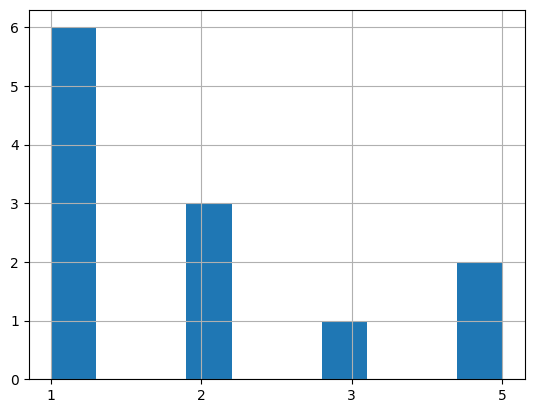

In [101]:
df['groundedness_score'].sort_values().hist(label='Groundedness Score')

<Axes: >

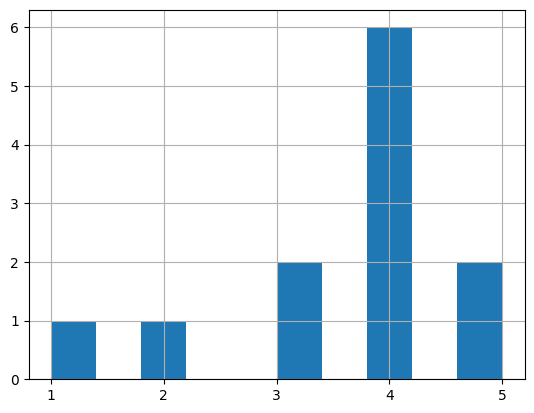

In [102]:
df['relevance_score'].sort_values().hist()

<Axes: >

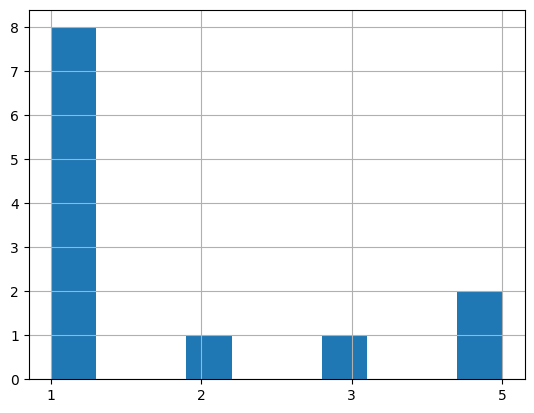

In [103]:
df['pair_quality_score'].sort_values().hist()

In [ ]:
# === 6. LLM-AS-A-JUDGE EVALUATION ===
# Following HuggingFace approach for answer quality evaluation

class LLMJudgeEvaluator:
    """
    LLM-as-a-judge evaluator following HuggingFace methodology
    """
    
    def __init__(self, llm_client: LLMClient):
        self.llm_client = llm_client
        
    # Evaluation prompt based on HuggingFace cookbook
    EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

    def evaluate_answer(self, question: str, generated_answer: str, reference_answer: str) -> Dict:
        """
        Evaluate a generated answer against reference using LLM-as-a-judge
        """
        prompt = self.EVALUATION_PROMPT.format(
            instruction=question,
            response=generated_answer,
            reference_answer=reference_answer
        )
        
        try:
            response = self.llm_client.call_llm(prompt, max_tokens=300, temperature=0.1)
            
            # Parse feedback and score
            if "[RESULT]" in response:
                parts = response.split("[RESULT]")
                feedback = parts[0].replace("Feedback:", "").strip()
                score_text = parts[1].strip()
                
                # Extract numeric score
                score = None
                for char in score_text:
                    if char.isdigit():
                        score = int(char)
                        break
                
                if score is None:
                    score = 1  # Default to lowest score if parsing fails
                    
                # Normalize score to 0-1 range
                normalized_score = (score - 1) / 4
                
                return {
                    "feedback": feedback,
                    "raw_score": score,
                    "normalized_score": normalized_score,
                    "evaluation_successful": True
                }
            else:
                return {
                    "feedback": "Failed to parse evaluation",
                    "raw_score": 1,
                    "normalized_score": 0.0,
                    "evaluation_successful": False
                }
                
        except Exception as e:
            return {
                "feedback": f"Evaluation failed: {str(e)}",
                "raw_score": 1,
                "normalized_score": 0.0,
                "evaluation_successful": False
            }

# Combined retrieval and generation evaluator
class RAGEvaluator:
    """
    Complete RAG evaluation combining retrieval metrics and LLM-as-a-judge
    """
    
    def __init__(self, llm_client: LLMClient):
        self.llm_judge = LLMJudgeEvaluator(llm_client)
        
    def evaluate_rag_system(self, retrieval_function, generation_function, 
                          qa_dataset: List[Dict], k: int = 3) -> Dict:
        """
        Comprehensive RAG evaluation
        
        Args:
            retrieval_function: Function that takes (question, k) and returns retrieved chunks
            generation_function: Function that takes (question, contexts) and returns answer
            qa_dataset: List of QA pairs with ground truth
            k: Number of chunks to retrieve
        """
        results = []
        overall_metrics = {
            'retrieval': {'precision_at_k': [], 'recall_at_k': [], 'mrr': [], 'ndcg_at_k': []},
            'generation': {'scores': [], 'normalized_scores': []}
        }
        
        print(f"🔄 Evaluating RAG system on {len(qa_dataset)} questions...")
        
        for i, qa_item in enumerate(qa_dataset):
            question = qa_item['question']
            reference_answer = qa_item['answer']
            ground_truth_chunk_id = qa_item.get('chunk_id', None)
            
            try:
                # 1. Evaluate retrieval
                retrieved_chunks = retrieval_function(question, k=k)
                
                # For retrieval evaluation, we use the source chunk as ground truth
                ground_truth_chunks = [ground_truth_chunk_id] if ground_truth_chunk_id is not None else []
                
                retrieval_metrics = self.evaluate_retrieval(retrieved_chunks, ground_truth_chunks, k)
                
                # 2. Generate answer using retrieved contexts
                contexts = [chunk.get('content', chunk.get('page_content', '')) for chunk in retrieved_chunks]
                generated_answer = generation_function(question, contexts)
                
                # 3. Evaluate generation quality
                generation_eval = self.llm_judge.evaluate_answer(question, generated_answer, reference_answer)
                
                # Store results
                result = {
                    'question': question,
                    'question_type': qa_item.get('question_type', 'unknown'),
                    'reference_answer': reference_answer,
                    'generated_answer': generated_answer,
                    'retrieved_chunks': retrieved_chunks,
                    'ground_truth_chunk': ground_truth_chunk_id,
                    'retrieval_metrics': retrieval_metrics,
                    'generation_evaluation': generation_eval
                }
                results.append(result)
                
                # Accumulate metrics
                for metric_name, value in retrieval_metrics.items():
                    overall_metrics['retrieval'][metric_name].append(value)
                
                overall_metrics['generation']['scores'].append(generation_eval['raw_score'])
                overall_metrics['generation']['normalized_scores'].append(generation_eval['normalized_score'])
                
                if (i + 1) % 5 == 0:
                    print(f"  ✅ Evaluated {i + 1}/{len(qa_dataset)} questions")
                    
            except Exception as e:
                print(f"  ❌ Error evaluating question {i + 1}: {str(e)}")
                continue
        
        # Calculate overall averages
        avg_metrics = {
            'retrieval': {},
            'generation': {}
        }
        
        for metric_name, values in overall_metrics['retrieval'].items():
            avg_metrics['retrieval'][metric_name] = np.mean(values) if values else 0.0
            
        avg_metrics['generation']['avg_score'] = np.mean(overall_metrics['generation']['scores']) if overall_metrics['generation']['scores'] else 0.0
        avg_metrics['generation']['avg_normalized_score'] = np.mean(overall_metrics['generation']['normalized_scores']) if overall_metrics['generation']['normalized_scores'] else 0.0
        
        return {
            'overall_metrics': avg_metrics,
            'detailed_results': results,
            'total_evaluated': len(results)
        }
    
    @staticmethod
    def evaluate_retrieval(retrieved_chunks, ground_truth_chunks, k=3):
        """Retrieval evaluation metrics"""
        if not retrieved_chunks or not ground_truth_chunks:
            return {'precision_at_k': 0.0, 'recall_at_k': 0.0, 'mrr': 0.0, 'ndcg_at_k': 0.0}
            
        retrieved_k = retrieved_chunks[:k]
        retrieved_ids = set([chunk.get('chunk_id', chunk.get('id', i)) for i, chunk in enumerate(retrieved_k)])
        ground_truth_ids = set(ground_truth_chunks)
        
        relevant_retrieved = len(retrieved_ids.intersection(ground_truth_ids))
        
        # Precision@K
        precision = relevant_retrieved / min(len(retrieved_k), k)
        
        # Recall@K  
        recall = relevant_retrieved / len(ground_truth_ids)
        
        # MRR
        mrr = 0.0
        for rank, chunk in enumerate(retrieved_k, 1):
            chunk_id = chunk.get('chunk_id', chunk.get('id', rank-1))
            if chunk_id in ground_truth_ids:
                mrr = 1.0 / rank
                break
        
        # NDCG@K (simplified)
        dcg = sum(1.0 / np.log2(rank + 1) for rank, chunk in enumerate(retrieved_k, 1) 
                 if chunk.get('chunk_id', chunk.get('id', rank-1)) in ground_truth_ids)
        idcg = sum(1.0 / np.log2(rank + 1) for rank in range(1, min(len(ground_truth_ids), k) + 1))
        ndcg = dcg / idcg if idcg > 0 else 0.0
        
        return {
            'precision_at_k': precision,
            'recall_at_k': recall,
            'mrr': mrr,
            'ndcg_at_k': ndcg
        }

# Initialize evaluator
rag_evaluator = RAGEvaluator(llm_client)
print("✅ LLM-as-a-judge RAG evaluator initialized")


In [ ]:
print("- Precision@K: Fraction of retrieved chunks that are relevant")
print("- Recall@K: Fraction of relevant chunks that are retrieved") 
print("- MRR: Mean Reciprocal Rank of first relevant chunk")
print("- NDCG@K: Normalized Discounted Cumulative Gain")

# Example evaluation
example_qa = synthetic_qa_dataset[0]
print(f"\n=== EXAMPLE EVALUATION ===")
print(f"Question: {example_qa['question']}")
print(f"Ground truth chunks: {example_qa['ground_truth_chunk_ids']}")

# Simulate retrieval results (in practice, this would come from your retrieval system)
simulated_retrieval = [
    {'chunk_id': example_qa['ground_truth_chunk_ids'][0]},  # First ground truth chunk
    {'chunk_id': 999},  # Irrelevant chunk
    {'chunk_id': example_qa['ground_truth_chunk_ids'][1] if len(example_qa['ground_truth_chunk_ids']) > 1 else 998}  # Second ground truth or irrelevant
]

metrics = RetrievalEvaluator.evaluate_retrieval(
    simulated_retrieval, 
    example_qa['ground_truth_chunk_ids'], 
    k=3
)

print(f"\nSimulated retrieval results: {[chunk['chunk_id'] for chunk in simulated_retrieval]}")
print("Evaluation metrics:")
for metric_name, value in metrics.items():
    print(f"  {metric_name}: {value:.3f}")


In [ ]:
# Save the synthetic QA dataset
import json
from datetime import datetime

# Create dataset metadata
dataset_metadata = {
    "name": "LGES_Synthetic_QA_Dataset",
    "description": "Synthetic question-answer dataset for evaluating retrieval in LGES RAG pipeline",
    "created_date": datetime.now().isoformat(),
    "total_questions": len(synthetic_qa_dataset),
    "question_types": type_counts,
    "difficulty_distribution": difficulty_counts,
    "source_text": "all_about_lges_text (2Q audit report summary + news summary)",
    "chunk_settings": {
        "chunk_size": 500,
        "chunk_overlap": 100,
        "total_chunks": len(chunks)
    }
}

# Prepare the complete dataset
complete_dataset = {
    "metadata": dataset_metadata,
    "questions": synthetic_qa_dataset,
    "chunks": [{"chunk_id": i, "content": chunk.page_content, "metadata": chunk.metadata if hasattr(chunk, 'metadata') else {}} 
              for i, chunk in enumerate(chunks)]
}

# Save to JSON file
output_file = "data/synthetic_qa_lges_dataset.json"
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(complete_dataset, f, indent=2, ensure_ascii=False)

print(f"✅ Synthetic QA dataset saved to: {output_file}")
print(f"📊 Dataset contains {len(synthetic_qa_dataset)} questions and {len(chunks)} chunks")


In [ ]:
# === 7. SAVE SYNTHETIC DATASET AND SETUP FOR EVALUATION ===

def save_synthetic_dataset(qa_dataset: List[Dict], chunks: List, filename: str = "data/synthetic_qa_lges_advanced.json"):
    """Save the generated synthetic dataset with metadata"""
    
    if not qa_dataset:
        print("⚠️  No QA dataset to save")
        return
        
    # Create dataset metadata
    type_counts = {}
    for qa in qa_dataset:
        qtype = qa["question_type"]
        type_counts[qtype] = type_counts.get(qtype, 0) + 1
    
    dataset_metadata = {
        "name": "LGES_Advanced_Synthetic_QA_Dataset",
        "description": "Advanced synthetic QA dataset generated using LLM with critique filtering",
        "created_date": datetime.now().isoformat(),
        "generation_method": "LLM-based with critique agents",
        "llm_provider": llm_client.provider,
        "llm_model": llm_client.model_name,
        "total_questions": len(qa_dataset),
        "question_types": type_counts,
        "source_text": "all_about_lges_text (2Q audit report + news summary)",
        "chunk_settings": {
            "chunk_size": 500,
            "chunk_overlap": 100,
            "total_chunks": len(chunks)
        },
        "evaluation_ready": True
    }
    
    # Prepare complete dataset
    complete_dataset = {
        "metadata": dataset_metadata,
        "qa_pairs": qa_dataset,
        "chunks": [
            {
                "chunk_id": i, 
                "content": chunk.page_content, 
                "metadata": chunk.metadata if hasattr(chunk, 'metadata') else {}
            } 
            for i, chunk in enumerate(chunks)
        ]
    }
    
    # Save to file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(complete_dataset, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Advanced synthetic dataset saved to: {filename}")
    print(f"📊 Contains {len(qa_dataset)} questions across {len(type_counts)} types")
    return filename

# Save the dataset
if synthetic_qa_dataset:
    dataset_file = save_synthetic_dataset(synthetic_qa_dataset, chunks)
else:
    print("⚠️  No synthetic dataset generated yet - run the generation cell above")


In [ ]:
# === 8. INTEGRATION GUIDE AND USAGE EXAMPLES ===

print("🔗 INTEGRATION WITH YOUR RAG SYSTEM")
print("=" * 50)

print("""
🚀 STEP 1: Define Your RAG Functions
────────────────────────────────────

# Example: Load your existing vector store
import pickle

# Load vector store (adapt to your setup)
with open('data/vector_stores/flat/index.pkl', 'rb') as f:
    vector_store = pickle.load(f)

# Define retrieval function
def my_retrieval_function(question, k=3):
    '''Retrieve relevant chunks for a question'''
    docs = vector_store.similarity_search(question, k=k)
    
    # Convert to expected format
    retrieved_chunks = []
    for i, doc in enumerate(docs):
        retrieved_chunks.append({
            'chunk_id': i,  # Map to actual chunk ID
            'content': doc.page_content,
            'score': getattr(doc, 'score', 0.0)
        })
    return retrieved_chunks

# Define generation function
def my_generation_function(question, contexts):
    '''Generate answer using retrieved contexts'''
    # Combine contexts
    context_text = "\\n\\n".join(contexts)
    
    # Generate answer (use your LLM client)
    prompt = f"Question: {question}\\n\\nContext: {context_text}\\n\\nAnswer:"
    answer = llm_client.call_llm(prompt, max_tokens=200)
    
    return answer

🚀 STEP 2: Run Complete RAG Evaluation
────────────────────────────────────

# Evaluate your complete RAG system
results = rag_evaluator.evaluate_rag_system(
    retrieval_function=my_retrieval_function,
    generation_function=my_generation_function,
    qa_dataset=synthetic_qa_dataset,
    k=3
)

🚀 STEP 3: Analyze Results
──────────────────────────

# Print overall metrics
print("RETRIEVAL METRICS:")
for metric, value in results['overall_metrics']['retrieval'].items():
    print(f"  {metric}: {value:.3f}")

print("\\nGENERATION METRICS:")
print(f"  Average Score: {results['overall_metrics']['generation']['avg_score']:.2f}/5")
print(f"  Normalized Score: {results['overall_metrics']['generation']['avg_normalized_score']:.3f}")

# Analyze by question type
import pandas as pd
df = pd.DataFrame(results['detailed_results'])
type_performance = df.groupby('question_type').agg({
    'generation_evaluation': lambda x: np.mean([eval_result['normalized_score'] for eval_result in x])
}).round(3)
print("\\nPerformance by Question Type:")
print(type_performance)
""")

print("\n💡 TIPS FOR IMPROVEMENT:")
print("─" * 25)
print("1. 📊 Experiment with different chunk sizes (200, 500, 1000 tokens)")
print("2. 🔄 Try different embedding models (OpenAI, sentence-transformers)")  
print("3. 🎯 Add reranking for better retrieval precision")
print("4. 📝 Improve generation prompts based on question types")
print("5. 🔍 Analyze failed cases to identify systematic issues")

print(f"\n✅ Setup complete! Your synthetic QA dataset is ready for evaluation.")
print(f"📁 Dataset saved with {len(synthetic_qa_dataset) if synthetic_qa_dataset else 0} questions")
print(f"🎯 Follow the HuggingFace methodology: {('https://huggingface.co/learn/cookbook/en/rag_evaluation')}")


In [13]:
len(chunks)

57